In [65]:
import numpy as np
import os
import os.path
import cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from math import modf#整数と小数の分離
import matplotlib.font_manager
import cv2
from sklearn import decomposition

import sys
sys.path.append("../../MypythonModule")
import mymodule
sys.path.append("../../Interactive_Graph_Visualizer/networkx-master")
import networkx as nx
sys.path.append("../../Webspace_Visualizer/Webspace_Visualizer")
import color_changer
import LDA_PCA
import make_lch_picker

In [66]:
def suffix_generator(target=None,is_largest=False):
    suffix = ""
    if target != None:
        suffix += "_" + target
    if is_largest == True:
        suffix += "_largest"
    return suffix

In [67]:
"""オプションを読みやすい形式で保存.前処理をしてから渡す"""
def save_drawoption(param_dict,path):
    #if param_dict.has_key("weited"):
    #	if param_dict["waited"]==NOWEIGHT:
    #		param_dict["waited"]="NOWEIGHT"
    #	elif param_dict["waited"]==ATTR_WEIGHT:
    #		param_dict["waited"]="ATTR_WEIGHT"
    #	elif param_dict["waited"]==REPUL_WEIGHT:
    #		param_dict["waited"]="REPUL_WEIGHT"
    #	elif param_dict["waited"]==BOTH_WEIGHT:
    #		param_dict["waited"]="BOTH_WEIGHT"
    mymodule.save_option(param_dict,path)

In [68]:
"""
HITSのパラメータに応じてノードのサイズを決定
@ret:{ノード番号:size}の辞書
"""
def calc_nodesize(G,attr="a_score",min_size=1000,max_size=5000):
    if type(attr) != str and type(attr) != unicode:
        normal_size = max_size-min_size
        normal_size = attr
        print "all size uniformed"
        return dict([(node_no,normal_size) for node_no in G.node])

    a_scores,h_scores=nx.hits(G)
    if attr == "a_score":
        use_vals = a_scores
    elif attr == "h_score":
        use_vals = h_scores
    else:
        print "invalid attribute"
        return

    max_val = max(use_vals.values())
    size_dict = dict()
    for node_no,node_attr in G.nodes(data=True):
        val = node_attr.get(attr)
        if val == None:
            size = min_size/2
        else:
            size = (val/max_val)*(max_size-min_size) + min_size
        size_dict[node_no] = size
    return size_dict

In [69]:
"""pathの位置に乱数があればそれを，無ければ新たに作る"""
def pos_initializer(G,path):
    if os.path.exists(path):
        with open(path) as fi:
            pos = pickle.load(fi)
        return pos

    pos = dict()
    for a, d in G.nodes(data=True):
        pos[a] = np.random.rand(2)
    with open(path,"w") as fo:
        pickle.dump(pos,fo)
    return pos


In [70]:
def draw_node_with_pie(G,pos,lda,size):
    theta = lda.theta()
    file_id_dict_inv = {v:k for k, v in lda.file_id_dict.items()}#ファイル名とLDAでの文書番号(逆引き)．LDAの方に作っとけばよかった．．．
    for serial_no,node_no in enumerate(G.node.keys()):
        draw_pos = pos[node_no]
        node_size = size[node_no]
        lda_no = file_id_dict_inv.get(node_no)
        if lda_no == None:
            pass
        else:
            theta_d = theta[lda_no]
            plt.pie(theta_d,colors=COLORLIST[:lda.K],startangle=90,radius=node_size, center=draw_pos, frame=False,counterclock=False)

In [71]:
def cvtRGB_to_HTML(RGB_1channel):
    R,G,B = RGB_1channel
    R_str = unicode("%02x"%R)
    G_str = unicode("%02x"%G)
    B_str = unicode("%02x"%B)
    return u"#"+R_str+G_str+B_str

In [72]:
def cvtLCH_to_HTML(LCH_1channel):
    lch_img = np.ones((2,2,3),dtype=np.float32)*LCH_1channel
    BGR_img = color_changer.cvtLCH2BGR(lch_img)
    RGB_img = cv2.cvtColor(BGR_img,cv2.COLOR_BGR2RGB)
    RGB_1channel = RGB_img[0,0]
    return cvtRGB_to_HTML(RGB_1channel)

In [73]:
"""1次元へのPCAをベースとして色変換を行う関数分岐"""
def get_color_map_phi(G,pos,lda,comp_type="COMP1",lumine=255):
    theta = lda.theta()[:len(lda.docs)]
    phi = lda.phi()
    psi_fake = lda.phi()*(lda.theta().sum(axis=0)[np.newaxis].T)
    phi = psi_fake

    #phi = (np.zeros_like(phi)+1)*(lda.theta().sum(axis=0)[np.newaxis].T)

    pca = decomposition.PCA(1)
    pca.fit(phi)
    phi_pca = pca.transform(phi)
    reg_phi_pca = (phi_pca-phi_pca.min())/(phi_pca.max()-phi_pca.min())#0~1に正規化
    h_values = (reg_phi_pca*np.pi).T[0]#列ヴェクトルとして与えられるため，1行に変換
    #LDA_PCA.topic_color_manager_1d(h_values,lda,lumine)#色変換の図を表示
    make_lch_picker.draw_half(h_values,lumine=lumine,with_label=False)#色変換の図を表示

    file_id_dict_inv = {v:k for k, v in lda.file_id_dict.items()}#ファイル名とLDAでの文書番号(逆引き)．LDAの方に作っとけばよかった．．．
    color_map = {}
    for serial_no,node_no in enumerate(G.node.keys()):
        lda_no = file_id_dict_inv.get(node_no)
        if lda_no == None:
            color_map[node_no] = r"#FFFFFF"
            continue
        theta_d = theta[lda_no]
        lch = theta_to_lch(theta_d,h_values,comp_type=comp_type,l=lumine)
        html_color = cvtLCH_to_HTML(lch)
        color_map[node_no] = html_color

    return color_map

In [74]:
def circler_color_converter(values,start_angle):
    values = values+start_angle*np.pi
    np.where(values<2*np.pi,values,values-2*np.pi)
    return values

In [75]:
def cvtRGBAflt2HTML(rgba):
    rgb = rgba[0][:3]
    rgb_uint = (rgb*255).astype(np.uint8)
    return LDA_PCA.cvtRGB_to_HTML(rgb_uint)

In [76]:
def get_color_map_theta(G,pos,lda,comp_type="COMP1",lumine=255,cmap="lch"):
    """thetaの方を主成分分析で1次元にして彩色"""
    theta = lda.theta()[:len(lda.docs)]

    pca = decomposition.PCA(1)
    pca.fit(theta)
    theta_pca = pca.transform(theta)
    reg_theta_pca = (theta_pca-theta_pca.min())/(theta_pca.max()-theta_pca.min())#0~1に正規化
    h_values = circler_color_converter(reg_theta_pca*2*np.pi,0.2).T[0]#列ヴェクトルとして与えられるため，1行に変換
    make_lch_picker.draw_color_hist(h_values,resolution=50,lumine=lumine)#色変換の図を表示

    if cmap == "lch":
        c_flt = 1.0
        file_id_dict_inv = {v:k for k, v in lda.file_id_dict.items()}#ファイル名とLDAでの文書番号(逆引き)．LDAの方に作っとけばよかった．．．
        color_map = {}
        for serial_no,node_no in enumerate(G.node.keys()):
            lda_no = file_id_dict_inv.get(node_no)
            if lda_no == None:
                color_map[node_no] = r"#FFFFFF"
                continue
            h_value = h_values[lda_no]
            lch = np.array((lumine,c_flt,h_value),dtype=np.float32)
            html_color = cvtLCH_to_HTML(lch)
            color_map[node_no] = html_color

    elif cmap == "jet":
        c_map = cm.jet
        file_id_dict_inv = {v:k for k, v in lda.file_id_dict.items()}#ファイル名とLDAでの文書番号(逆引き)．LDAの方に作っとけばよかった．．．
        color_map = {}
        for serial_no,node_no in enumerate(G.node.keys()):
            lda_no = file_id_dict_inv.get(node_no)
            if lda_no == None:
                color_map[node_no] = r"#FFFFFF"
                continue
            color_map[node_no] = cvtRGBAflt2HTML(c_map(reg_theta_pca[lda_no]))

    return color_map

In [77]:
"""色相をPCAの1次元で，彩度をそれぞれのトピック分布の各比率で合成(composition)"""
def draw_node_with_lch(G,pos,lda,size,comp_type="COMP1",lumine=255,color_map_by="phi",cmap="lch"):
    if color_map_by == "phi":
        color_map = get_color_map_phi(G,pos,lda,comp_type,lumine=lumine)
        node_color = color_map.values()
    elif color_map_by == "theta":
        color_map = get_color_map_theta(G,pos,lda,comp_type,lumine=lumine,cmap=cmap)
        node_color = color_map.values()
    elif color_map_by == None:
        node_color = ["#FFFFFF"]*len(G.node)
    size_array = size.values()
    nx.draw_networkx_nodes(G,pos=pos,node_color=node_color,node_size=size_array,pick_func=pick_function);

In [78]:
"""トピック分布から色を1色決定し，lchの形で返す"""
def theta_to_lch(theta_d,h_values,comp_type="COMP1",l=100):
    if comp_type == "REPR2":#色相をPCAの1次元で，彩度をそれぞれの最大トピックの値で返す
        c = theta_d.max()
        rep_topic = theta_d.argmax()
        h = h_values[rep_topic]
        lch = np.array((l,c,h),dtype=np.float32)
    elif comp_type == "COMP1":#色相をPCAの1次元で，彩度をそれぞれのトピック分布の各比率で合成(composition)
        orth_vals = np.array([color_changer.cvt_polar_to_orth(theta_t,h_values[k]) for k,theta_t in enumerate(theta_d)],dtype=np.float32)
        orth_vals = orth_vals.sum(axis=0)
        c_flt = np.sqrt(orth_vals[0]**2+orth_vals[1]**2)
        h_flt = np.arctan2(orth_vals[1],orth_vals[0])
        lch = np.array((l,c_flt,h_flt),dtype=np.float32)

    return lch

In [79]:
"""消えてしまった軸を復活させる(たい)．大仰なやり方なうえ不十分だが一応見るに堪える形式"""
def draw_axis(xstep,ystep=None):
    if(ystep == None):
        ystep = xstep
    xmin,xmax,ymin,ymax = plt.axis()
    xmin = modf(xmin/xstep)[1]*xstep
    ymin = modf(ymin/ystep)[1]*ystep
    plt.xticks(np.arange(xmin,xmax,ystep))#なぜか座標軸が消えるので補完
    plt.yticks(np.arange(ymin,ymax,xstep))#なぜか座標軸が消えるので補完

In [80]:
"""{ノード番号:値}で与えられた辞書の穴を埋めてリスト化.keyとして数字が入っており，かつそれが昇順に並んでいることを前提．Deprecated"""
def convert_nodeDict_to_array(node_dict,default_val=0):
    max_no = node_dict.keys()[-1]
    ret_list = [default_val]*(max_no+1)
    for k,v in node_dict.items():
        ret_list[k] = v
    return ret_list

In [81]:
"""ノードおよびエッジを描画する．オプションによって動作指定"""
def draw_network(G,pos,size,option="REPR",lda=None,dpi=100,with_label=True,lumine=255,color_map_by="phi",cmap="lch"):
    if option == "REPR":
        color_map = nx.get_node_attributes(G,"color")
        size_array = size.values()
        #nx.draw(G,pos=pos,with_labels=True)#with_labelsは各ノードのラベル表示.この関数事体を呼ばずに下二つを呼ぶと軸ラベルがつく．内部的にはいろいろ処理した後下二つを呼んでる
        nx.draw_networkx_nodes(G,pos=pos,node_color=color_map.values(),node_size=size_array);
        #nx.draw_networkx_edges(G,pos,font_size=int(12*100/dpi))
    elif option == "PIE":
        draw_node_with_pie(G,pos,lda,size)
        #draw_axis(xstep=0.2,ystep=0.2)#なぜか上処理で軸が消えてしまうため書き直す
    elif option == "REPR2" or option == "COMP1" or option == "COMP2":
        draw_node_with_lch(G,pos,lda,size,comp_type=option,lumine=lumine,color_map_by=color_map_by,cmap=cmap)

    nx.draw_networkx_edges(G,pos)
    if with_label == True:
        nx.draw_networkx_labels(G,pos,font_size=int(12*100/dpi))

In [82]:
def pick_function(event):
    global G_global
    ind = event.ind
    ax = plt.gca()
    fig = ax.get_figure()
    for i in ind:
        print ind,"file_no=",G_global.node.keys()[i]
        fig.text(1,-1,unicode(G_global.node.keys()[i]),fontproperties=prop)
    #print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))

In [83]:
search_word = u"iPhone"
max_page = 5
root_dir = "Data/Search_" + search_word + "_" + unicode(max_page) + "_add_childs_append" 
is_largest = True
G_name = "G" + suffix_generator(is_largest=is_largest)
target = "myexttext"
use_to_link = "to_ext_links"

In [84]:
K = 10
iteration = 50
alpha = 0.001
beta = 0.001
no_below = 5#単語の最低出現文書数
no_above = 0.3#単語の最大出現文書比率
no_less = 20#文書に含まれる最低単語数
do_hparam_update = False#パラメータを更新するか否か

chasen_dir_name = "Chasen" + suffix_generator(target,is_largest)
exp_name = "K" + unicode(K) + suffix_generator(target,is_largest)
comment = None

In [85]:
comp_func_name = "comp4_2"
void_node_remove = True#空のノード(LDA結果のないノード)を除去するかどうか

In [86]:
draw_option={
    "comp_func_name":comp_func_name,
    #"weight_type":[],
    "weight_type":["ATTR","REPUL"],
    #"weight_type":["ATTR","REPUL","HITS"],#オーソリティかハブかはsize_attrで指定
    # "node_type":"COMP1",
    "node_type":"REPR",
    #"node_type":"PIE",
    "do_rescale":True,
    "with_label":False,
    #"size_attr":"a_score",
    #"size_attr":0.02,
    "size_attr":2000,
    "lumine":200,
    "cmap":"jet",
    #"color_map_by":"phi"
    "color_map_by":"theta"
    #"color_map_by":"pie"
    #"color_map_by":None
    }

In [87]:
nx_dir = os.path.join(os.path.join(root_dir,exp_name),"nx_datas")
src_pkl_name = "G_with_params_" + comp_func_name + ".gpkl"
weights_pkl_name = "all_node_weights_" + comp_func_name + ".gpkl"

In [88]:
G_global = None

In [89]:
exp_dir = os.path.join(root_dir,exp_name)
nx_process_dir = os.path.join(nx_dir,"process")

In [90]:
with open(os.path.join(nx_dir,src_pkl_name),"r") as fi:
    G = pickle.load(fi)
with open(os.path.join(nx_dir,weights_pkl_name)) as fi:
    all_node_weights = pickle.load(fi)
with open(os.path.join(exp_dir,"instance.pkl")) as fi:
   lda = pickle.load(fi)

In [91]:
weight_type = draw_option.get("weight_type",["ATTR","REPUL"])
comp_func_name = draw_option.get("comp_func_name","comp1_1")
node_type = draw_option.get("node_type","REPR")
do_rescale = draw_option.get("do_rescale",True)
with_label = draw_option.get("with_label",True)
size_attr = draw_option.get("size_attr","None")
lumine = draw_option.get("lumine",255)
save_drawoption(draw_option,os.path.join(nx_dir,"draw_option.txt"))
color_map_by = draw_option.get("color_map_by","phi")
cmap = draw_option.get("cmap","lch")

In [92]:
new_all_nodes_weights = all_node_weights
new_all_nodes_weights

array([[ 1.        ,  0.70424899,  0.64309846, ...,  0.3461291 ,
         0.2470108 ,  0.29506001],
       [ 0.70424899,  1.        ,  0.99478672, ...,  0.59493346,
         0.43049698,  0.48893982],
       [ 0.64309846,  0.99478672,  1.        , ...,  0.60614034,
         0.43945303,  0.49648501],
       ..., 
       [ 0.3461291 ,  0.59493346,  0.60614034, ...,  1.        ,
         0.89786772,  0.66544784],
       [ 0.2470108 ,  0.43049698,  0.43945303, ...,  0.89786772,
         1.        ,  0.71037907],
       [ 0.29506001,  0.48893982,  0.49648501, ...,  0.66544784,
         0.71037907,  1.        ]])

In [93]:
G_undirected = G#適切なスプリングモデルのためには無向グラフである必要あり
if G.is_directed():
    G_undirected = G.to_undirected()
global G_global
G_global = G_undirected

len(G_global.node.keys())


42

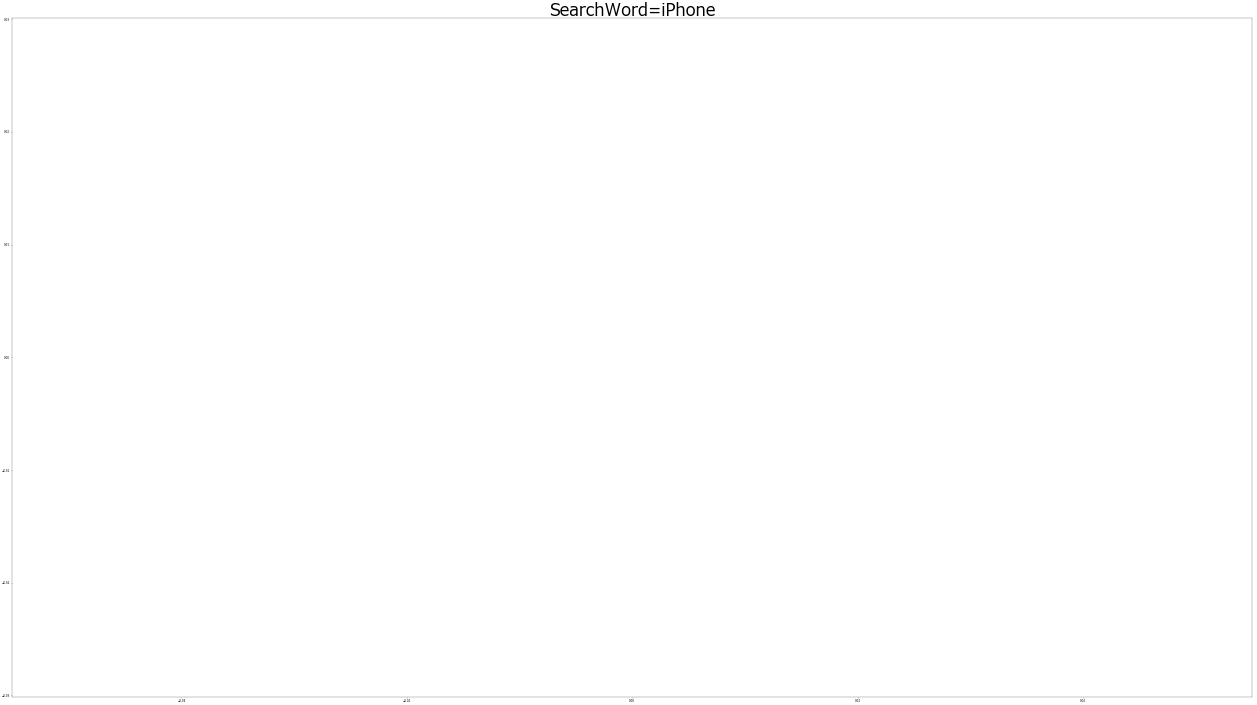

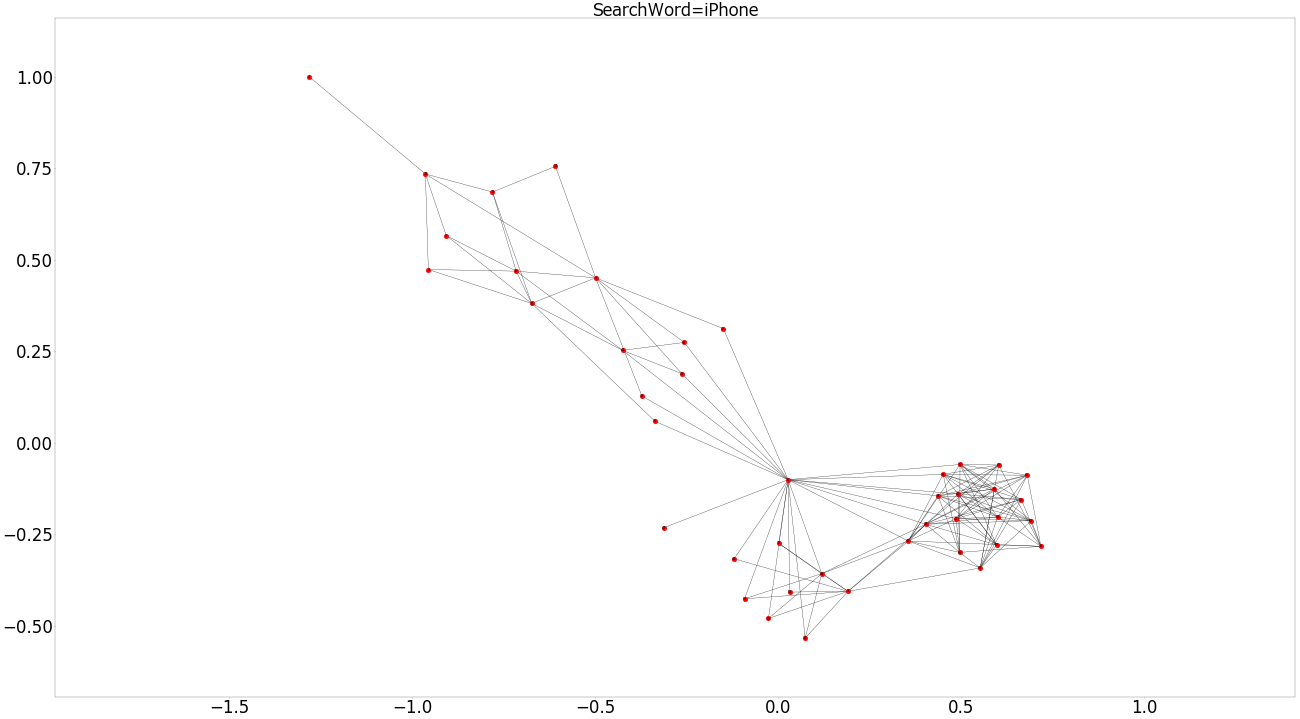

In [94]:
nx.draw_networkx(G_global)
plt.show()

In [95]:
revised_hits_scores = calc_nodesize(G,attr=size_attr,min_size=1,max_size=3)#引力斥力計算用に正規化したhitsスコア
revised_hits_scores

all size uniformed


{0: 2000,
 1: 2000,
 2: 2000,
 3: 2000,
 4: 2000,
 6: 2000,
 8: 2000,
 9: 2000,
 10: 2000,
 12: 2000,
 13: 2000,
 14: 2000,
 31: 2000,
 32: 2000,
 33: 2000,
 34: 2000,
 35: 2000,
 36: 2000,
 37: 2000,
 38: 2000,
 39: 2000,
 40: 2000,
 41: 2000,
 42: 2000,
 43: 2000,
 44: 2000,
 45: 2000,
 47: 2000,
 48: 2000,
 49: 2000,
 50: 2000,
 52: 2000,
 53: 2000,
 59: 2000,
 60: 2000,
 61: 2000,
 62: 2000,
 63: 2000,
 65: 2000,
 66: 2000,
 67: 2000,
 68: 2000}

In [96]:
dpi = 20
prop.set_size(int(12*100/dpi))

In [97]:
initial_pos = pos_initializer(G_undirected,os.path.join(root_dir,"nest1.rand"))
initial_pos

{0: array([ 0.71370264,  0.8948053 ]),
 1: array([ 0.53013538,  0.50832084]),
 2: array([ 0.91868693,  0.87502405]),
 3: array([ 0.06591412,  0.15817481]),
 4: array([ 0.21255459,  0.14264263]),
 6: array([ 0.0242707,  0.2891225]),
 8: array([ 0.00108663,  0.56144382]),
 9: array([ 0.73811276,  0.13758685]),
 10: array([ 0.7469388 ,  0.38230224]),
 12: array([ 0.36549116,  0.9894899 ]),
 13: array([ 0.43652152,  0.61995565]),
 14: array([ 0.37426261,  0.52162132]),
 31: array([ 0.14212745,  0.43758786]),
 32: array([ 0.48447398,  0.2666447 ]),
 33: array([ 0.93186802,  0.68213029]),
 34: array([ 0.90597186,  0.61938709]),
 35: array([ 0.03293614,  0.59239576]),
 36: array([ 0.92813744,  0.41667202]),
 37: array([ 0.28891659,  0.96282856]),
 38: array([ 0.91107657,  0.10044667]),
 39: array([ 0.00363965,  0.36580019]),
 40: array([ 0.21248689,  0.24680806]),
 41: array([ 0.14734585,  0.83611476]),
 42: array([ 0.43726586,  0.46980651]),
 43: array([ 0.85502706,  0.92082379]),
 44: array

In [98]:
pos = initial_pos
pos

{0: array([ 0.71370264,  0.8948053 ]),
 1: array([ 0.53013538,  0.50832084]),
 2: array([ 0.91868693,  0.87502405]),
 3: array([ 0.06591412,  0.15817481]),
 4: array([ 0.21255459,  0.14264263]),
 6: array([ 0.0242707,  0.2891225]),
 8: array([ 0.00108663,  0.56144382]),
 9: array([ 0.73811276,  0.13758685]),
 10: array([ 0.7469388 ,  0.38230224]),
 12: array([ 0.36549116,  0.9894899 ]),
 13: array([ 0.43652152,  0.61995565]),
 14: array([ 0.37426261,  0.52162132]),
 31: array([ 0.14212745,  0.43758786]),
 32: array([ 0.48447398,  0.2666447 ]),
 33: array([ 0.93186802,  0.68213029]),
 34: array([ 0.90597186,  0.61938709]),
 35: array([ 0.03293614,  0.59239576]),
 36: array([ 0.92813744,  0.41667202]),
 37: array([ 0.28891659,  0.96282856]),
 38: array([ 0.91107657,  0.10044667]),
 39: array([ 0.00363965,  0.36580019]),
 40: array([ 0.21248689,  0.24680806]),
 41: array([ 0.14734585,  0.83611476]),
 42: array([ 0.43726586,  0.46980651]),
 43: array([ 0.85502706,  0.92082379]),
 44: array

In [99]:
plt.figure(figsize=(1600/dpi, 900/dpi), dpi=dpi)
plt.title("SearchWord="+search_word,fontproperties=prop)
plt.axis('equal')#両軸を同じスケールに
plt.rcParams["font.size"]=int(12*100/dpi)
plt.gcf().set_facecolor('w')

In [100]:
if "ATTR" in weight_type:
    if "REPUL" in weight_type:
        pos = nx.spring_layout(G_undirected,pos=pos,all_node_weights=new_all_nodes_weights,rescale=do_rescale,weight_type=weight_type,revised_hits_scores=revised_hits_scores)#描画位置はここで確定,両方の重みをかける
    else:
        pos = nx.spring_layout(G_undirected,pos=initial_pos,all_node_weights=np.ones(1))#描画位置はここで確定,全ノードの重みを1にするので重みがかかるのは引力計算のみ
elif "REPUL" in weight_type:
    pos = nx.spring_layout(G_undirected,pos=initial_pos,all_node_weights=new_all_nodes_weights,weight="wei")#描画位置はここで確定,重みがかかるのは斥力計算のみ
else:
    pos = nx.spring_layout(G_undirected,pos=initial_pos,weight="wei")#描画位置はここで確定

In [101]:
pos

{0: array([ 0.31073395,  0.94583929]),
 1: array([ 0.79530685, -0.48933061]),
 2: array([ 0.78380306,  0.62715987]),
 3: array([-0.66751342, -0.71744791]),
 4: array([-0.12184791, -0.95384373]),
 6: array([-0.83721626, -0.50903038]),
 8: array([-0.97767165, -0.09964236]),
 9: array([ 0.31014941, -0.9151869 ]),
 10: array([ 0.64095718, -0.70678483]),
 12: array([-0.02052075,  1.        ]),
 13: array([ 0.13232728,  0.95554076]),
 14: array([-0.94597417,  0.05648005]),
 31: array([-0.90039162, -0.34997299]),
 32: array([ 0.01366194, -0.94733718]),
 33: array([ 0.9238116 ,  0.35920194]),
 34: array([ 0.95891955,  0.21788367]),
 35: array([-0.96733509,  0.18614153]),
 36: array([ 0.90042572, -0.37323931]),
 37: array([-0.3273794 ,  0.94597629]),
 38: array([ 0.76694655, -0.62079546]),
 39: array([-0.95298   , -0.24234268]),
 40: array([-0.54415124, -0.79343187]),
 41: array([-0.68079948,  0.72610105]),
 42: array([ 0.4107509 , -0.82797619]),
 43: array([ 0.47047844,  0.88779387]),
 44: arr

In [102]:
len(pos)

42

In [103]:
size_dict = calc_nodesize(G,attr=size_attr,min_size=1000,max_size=3000)
size_dict

all size uniformed


{0: 2000,
 1: 2000,
 2: 2000,
 3: 2000,
 4: 2000,
 6: 2000,
 8: 2000,
 9: 2000,
 10: 2000,
 12: 2000,
 13: 2000,
 14: 2000,
 31: 2000,
 32: 2000,
 33: 2000,
 34: 2000,
 35: 2000,
 36: 2000,
 37: 2000,
 38: 2000,
 39: 2000,
 40: 2000,
 41: 2000,
 42: 2000,
 43: 2000,
 44: 2000,
 45: 2000,
 47: 2000,
 48: 2000,
 49: 2000,
 50: 2000,
 52: 2000,
 53: 2000,
 59: 2000,
 60: 2000,
 61: 2000,
 62: 2000,
 63: 2000,
 65: 2000,
 66: 2000,
 67: 2000,
 68: 2000}

In [108]:
draw_network(G,pos,size=size_dict,option=node_type,lda=lda,dpi=dpi,with_label=with_label,lumine=lumine,color_map_by=color_map_by,cmap=cmap)

In [109]:
plt.savefig(os.path.join(nx_process_dir,"graph.png"))

IOError: [Errno 2] No such file or directory: u'Data/Search_iPhone_5_add_childs_append/K10_myexttext_largest/nx_datas/process/graph.png'